# Towards Robust Interpretability with Self-Explaining Neural Networks

Authors: *Rico Mossinkoff, Yke Rusticus, Roberto Schiavone, Ewoud Vermeij*

In [9]:
import warnings
warnings.filterwarnings("ignore")

from api import mnist, compas
from api.load import load_compas, load_mnist, RegLambda, HType, NConcepts
from api.utils import MNIST_TEST_SET

## MNIST
For the MNIST dataset, it is possible to load various models specifying the following parameters to the `load_mnist` function:
- `h_type=HType.INPUT` and `reg_lambda`
- `h_type=HType.CNN`, `reg_lambda` and `n_concepts`

If `load_mnist` is called with `h_type=HType.INPUT` and `n_concepts`, `n_concepts` is safely ignored.

The default parameters for MNIST are `h_type=HType.INPUT`, `n_concepts=NConcepts.FIVE` and `reg_lambda=RegLambda.E4`

The possible values for each parameter are shown below.

In [10]:
print('h_type possible values:')
for x in HType:
    print(x)

h_type possible values:
HType.CNN
HType.INPUT


In [11]:
print('reg_lambda possible values:')
for x in RegLambda:
    value = ('{:0.0e}' if x.value != 0 and x.value != 1 else '{}').format(x.value)
    print(str(x) + ': ' + value)

reg_lambda possible values:
RegLambda.ZERO: 0
RegLambda.E4: 1e-04
RegLambda.E3: 1e-03
RegLambda.E2: 1e-02
RegLambda.E1: 1e-01
RegLambda.ONE: 1


In [12]:
print('n_concepts possible values:')
for x in NConcepts:
    print(str(x) + ': ' + str(x.value))

n_concepts possible values:
NConcepts.FIVE: 5
NConcepts.TWENTY: 20


In [13]:
model = load_mnist(n_concepts=NConcepts.FIVE)
# equivalent
# model = load_mnist(reg_lambda=RegLambda.E4, h_type=HType.CNN, n_concepts=NConcepts.FIVE)

Loading MNIST model grad3_Hcnn_Thsimple_Cpts5_Reg1e-04_Sp2e-05_LR0.0002:
> conceptizer type        = cnn
> number of concepts      = 5
> sparsity parameter      = 2e-05
> regularization strength = 1e-04


In [14]:
digit = mnist.get_digit_image(5)
n=5

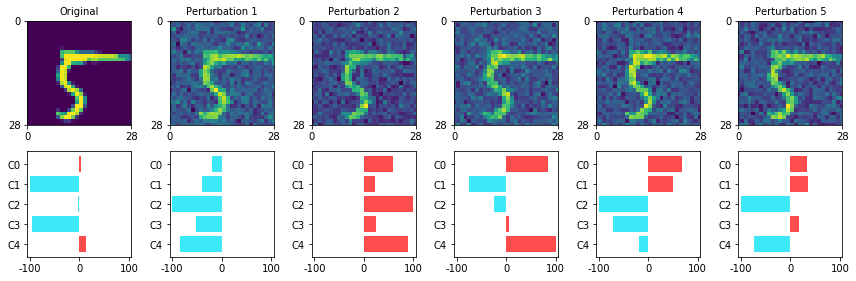

In [15]:
mnist.plot_digit_noise_activation(model, n, 5)

In [16]:
model = load_compas(RegLambda.ONE)

Loading MNIST model grad3_Hinput_Thsimple_Reg1e+00_LR0.0002:
> conceptizer type        = input
> regularization strength = 1


In [17]:
x = {
    'Two_yr_Recidivism': 1., 
     'Number_of_Priors': 1.,
     'Age_Above_FourtyFive': 1.,
     'Age_Below_TwentyFive':1.,
     'African_American': 1.,
     'Asian': 1., 
     'Hispanic': 1.,
     'Native_American': 1.,
     'Other':1.,
     'Female': 0.,
     'Misdemeanor': 1.
    }

  1%|▏         | 86/6172 [00:00<00:07, 841.91it/s]

/home/evermeij/Documents/Github/FACT/SENN/data/fairml/doc/example_notebooks/propublica_data_for_fairml.csv


100%|██████████| 6172/6172 [00:03<00:00, 1726.16it/s]


[2, 3]


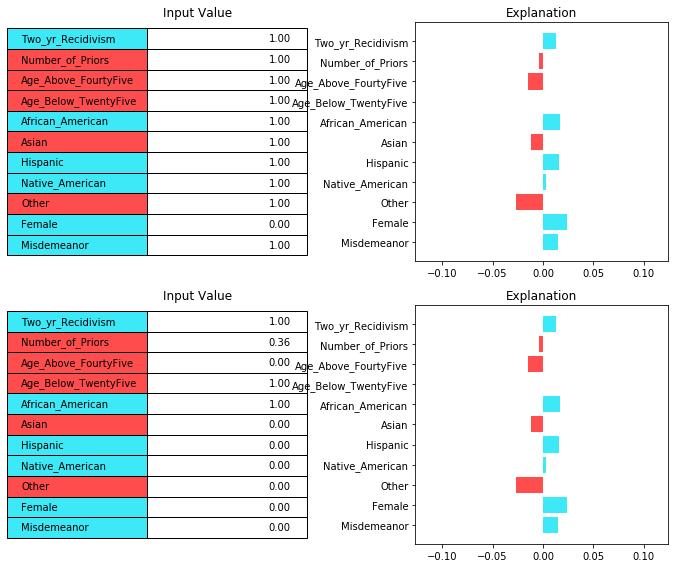

In [18]:
compas.plot_lipschitz_feature(model, x)

# Model evaluations


In [19]:
_, _, _, _, _, test , _, _ = compas.load_compas_data(shuffle=False, batch_size=64)

  1%|▏         | 90/6172 [00:00<00:07, 842.26it/s]

/home/evermeij/Documents/Github/FACT/SENN/data/fairml/doc/example_notebooks/propublica_data_for_fairml.csv


100%|██████████| 6172/6172 [00:03<00:00, 1740.44it/s]


In [20]:
print("<--------COMPAS MODELS-------->")
compass_acc = []
for reg in RegLambda:
    model = load_compas(reg, False)
    acc = compas.evaluate(model, test, print_freq=0, return_acc=True)
    compass_acc.append(acc)
    strreg = ("Lambda: " + str(reg)[10:] + ",").ljust(14, ' ')
    print("COMPAS model - %s accuracy: %0.4f" %(strreg, acc))

print("\n<--------MNIST MODELS--------->")
mnist_acc = []
for ht in HType:
    for concept in NConcepts:
        for reg in RegLambda:
            model = load_mnist(reg, ht, concept, False)
            acc = mnist.evaluate(model, MNIST_TEST_SET, print_freq=0, return_acc=True)
            mnist_acc.append(acc)            
            strht = ("h(x): "+str(ht)[6:] + ",").ljust(14, ' ')
            strconcept = ("nconcepts: "+str(concept)[10:] + ",").ljust(20, ' ')
            strreg = ("Lambda: " + str(reg)[10:] + ",").ljust(15, ' ')
            print("MNIST model - %s %s %s accuracy: %0.5f" %(strht, strconcept, strreg, acc))
            

<--------COMPAS MODELS-------->
COMPAS model - Lambda: ZERO,  accuracy: 0.8153
COMPAS model - Lambda: E4,    accuracy: 0.8060
COMPAS model - Lambda: E3,    accuracy: 0.8134
COMPAS model - Lambda: E2,    accuracy: 0.8041
COMPAS model - Lambda: E1,    accuracy: 0.7910
COMPAS model - Lambda: ONE,   accuracy: 0.6754

<--------MNIST MODELS--------->
MNIST model - h(x): CNN,     nconcepts: FIVE,     Lambda: ZERO,   accuracy: 0.98850
MNIST model - h(x): CNN,     nconcepts: FIVE,     Lambda: E4,     accuracy: 0.98750
MNIST model - h(x): CNN,     nconcepts: FIVE,     Lambda: E3,     accuracy: 0.98650
MNIST model - h(x): CNN,     nconcepts: FIVE,     Lambda: E2,     accuracy: 0.98250
MNIST model - h(x): CNN,     nconcepts: FIVE,     Lambda: E1,     accuracy: 0.96580
MNIST model - h(x): CNN,     nconcepts: FIVE,     Lambda: ONE,    accuracy: 0.15570
MNIST model - h(x): CNN,     nconcepts: TWENTY,   Lambda: ZERO,   accuracy: 0.99100
MNIST model - h(x): CNN,     nconcepts: TWENTY,   Lambda: E4,    

# Image, activations, concept prototypes

In [21]:
model = load_mnist(n_concepts=NConcepts.FIVE)

Loading MNIST model grad3_Hcnn_Thsimple_Cpts5_Reg1e-04_Sp2e-05_LR0.0002:
> conceptizer type        = cnn
> number of concepts      = 5
> sparsity parameter      = 2e-05
> regularization strength = 1e-04


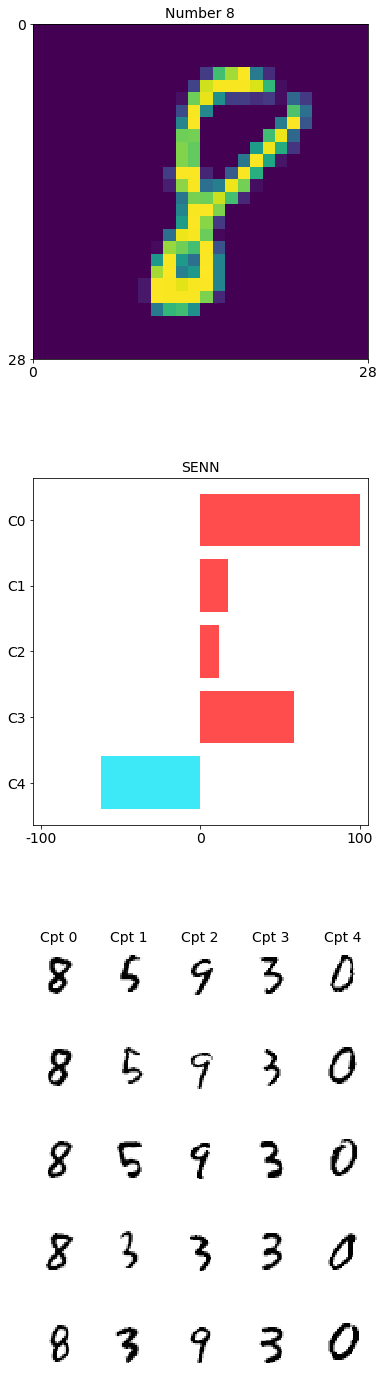

In [24]:
mnist.im_act_con_plot(model, 8, layout='vertical', top_k=5)